In [1]:
from functions_text_model import *
import os

In [8]:

from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
import json
from transformers import BertForSequenceClassification, BertTokenizer
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.utils.data import random_split



# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Function to encode the text
def encode_text(text):
    encoded_dict = tokenizer.encode_plus(
                        text,                      # Input text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors
                   )
    return encoded_dict['input_ids'], encoded_dict['attention_mask']

# PyTorch Dataset
class SarcasmDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        utterance = item['utterance']
        sarcasm = int(item['sarcasm'])
        input_ids, attention_mask = encode_text(utterance)
        return input_ids.flatten(), attention_mask.flatten(), sarcasm
# Create the DataLoader
# Load the data from the JSON file
with open('sarcasm_data.json') as f:
    data = json.load(f)

# Convert the data to a list of dictionaries
data = list(data.values())

dataset = SarcasmDataset(data)
dataloader = DataLoader(dataset, batch_size=32)
#dataset = SarcasmDataset('sarcasm_data.json')
#dataloader = DataLoader(dataset, batch_size=32)

train Loss: 0.1322,  ACC: 0.9565, F1-weighted: 0.9517


100%|██████████| 18/18 [00:11<00:00,  1.59it/s]


eval Loss: 0.8281,  ACC: 0.6458, F1-weighted: 0.5679


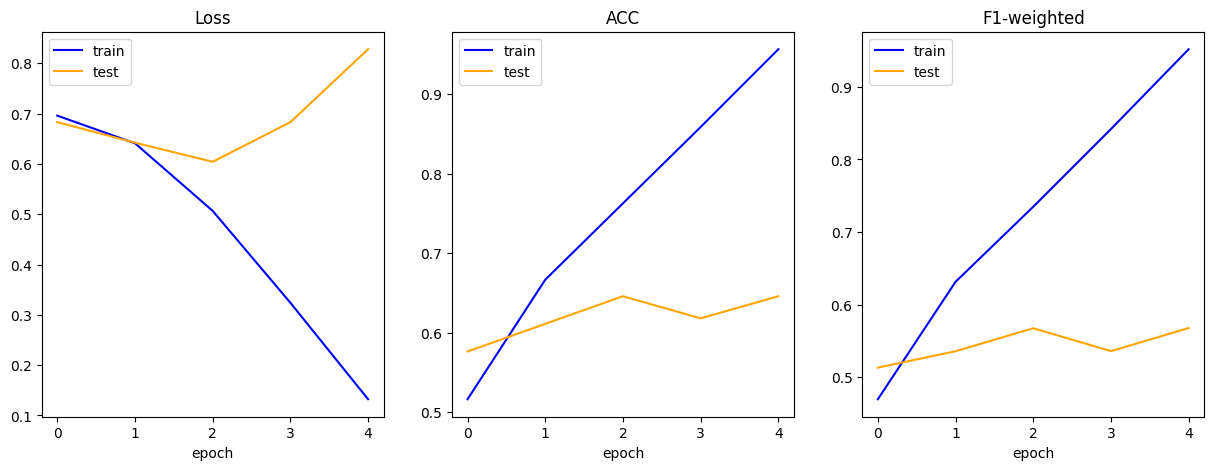

Model trained and saved!


In [7]:
torch.manual_seed(42)

# Load BERT model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the base BERT model
    num_labels = 2, # Binary classification (sarcasm or not)
    output_attentions = False, # Whether the model returns attentions weights
    output_hidden_states = False, # Whether the model returns all hidden-states
)

# Load the BERT tokenizer
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

#HYPEPARAMETERs TO TUNE
learning_rate = 0.001
N_EPOCHS = 5
batchsize = 8

# Define the size of the training set and the test set
train_size = int(0.8 * len(dataset))  # 80% of the data for training
test_size = len(dataset) - train_size  # 20% of the data for testing

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create the DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batchsize)
test_dataloader = DataLoader(test_dataset, batch_size=batchsize)

# Set device
device = torch.device("cpu")

# Move the model to the CPU
model.to(device)

# Create the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()


metrics = {'ACC': acc, 'F1-weighted': f1}


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_metrics_log, test_metrics_log = train_cycle(model, optimizer, criterion, metrics, train_dataloader, test_dataloader, n_epochs=N_EPOCHS, device=device)

# save model weights
results_models_weights_dir = 'models_weights/'
if not os.path.exists(results_models_weights_dir):
    os.mkdir(results_models_weights_dir)
torch.save(model.state_dict(), results_models_weights_dir + 'base_model_trained_on_augmented_set.pth')

print('Model trained and saved!')

In [4]:
model.load_state_dict(torch.load(results_models_weights_dir + 'base_model_trained_on_augmented_set.pth'))

<All keys matched successfully>

In [5]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,